# TabPFN Missing Value Imputation vs Classical Anomaly Detection Methods

실험 가설: **TabPFN imputation 성능이 낮을수록 anomaly일 가능성이 높다**

- TabPFN missing value reconstruction error를 anomaly score로 사용
- Isolation Forest, One-Class SVM, Local Outlier Factor 등과 성능 비교
- AUC, Accuracy 메트릭으로 비교

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# TabPFN imports
try:
    from tabpfn import TabPFNClassifier
except ImportError:
    print("TabPFN not available, using fallback")
    TabPFNClassifier = None

# Load dataset
import sys
sys.path.append('resad_table')
from resad_table.datasets.tabular_loader import ADBenchDataLoader

plt.style.use('default')
sns.set_palette("husl")

## 1. 데이터 로드 및 준비

In [20]:
# 데이터 로더 초기화
data_loader = ADBenchDataLoader('dataset/Classical', normalize=True)

# 테스트할 데이터셋들
datasets = ['breastw', 'pima', 'wdbc', 'wine', 'glass']
results = {}

print("Loading datasets...")
for dataset_name in datasets:
    try:
        # Load test split for evaluation
        dataset = data_loader.load_dataset(dataset_name, train=False, test_size=0.3, random_state=42)
        
        X = dataset.X_split
        y = dataset.y_split  # 0: normal, 1: anomaly
        
        results[dataset_name] = {
            'X': X,
            'y': y,
            'feature_names': dataset.feature_names
        }
        
        normal_count = np.sum(y == 0)
        anomaly_count = np.sum(y == 1)
        print(f"{dataset_name}: Total={len(X)}, Normal={normal_count}, Anomaly={anomaly_count}, Features={X.shape[1]}")
        
    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")

print(f"\nLoaded {len(results)} datasets successfully")

Loading datasets...
breastw: Total=205, Normal=133, Anomaly=72, Features=9
pima: Total=231, Normal=150, Anomaly=81, Features=8
wdbc: Total=111, Normal=108, Anomaly=3, Features=30
wine: Total=39, Normal=36, Anomaly=3, Features=13
glass: Total=65, Normal=62, Anomaly=3, Features=7

Loaded 5 datasets successfully


## 2. TabPFN Missing Value Imputation 기반 Anomaly Detection
- missing imputation: 전체 데이터 중 랜덤으로 masking하고 재현, 차이가 클수록 이상치
- missing imputation2: 전체 변수 중 랜덤으로 선정된 절반의 변수로 나머지 절반의 변수 값들을 재현. 차이가 클수록 이상치.

In [21]:
import numpy as np
import pandas as pd

def split_features(n_features, random_state=42):
    """Randomly split columns into X (features) and Y (targets) with half-half"""
    rng = np.random.default_rng(random_state)
    perm = rng.permutation(n_features)
    half = n_features // 2 +1
    X_cols = perm[:half]
    Y_cols = perm[half:]
    print(f"features split into {X_cols} X and {Y_cols} Y")
    return X_cols, Y_cols

def tabpfn_xy_reconstruction_anomaly_scores(X, n_trials=3):
    """Anomaly scores based on TabPFN predicting random half columns (Y) from other half (X)"""
    n_samples, n_features = X.shape
    reconstruction_errors = np.zeros(n_samples, dtype=float)

    for trial in range(n_trials):
        # 1) Randomly split columns: X (input), Y (to predict)
        X_cols, Y_cols = split_features(n_features, random_state=42 + trial)

        # 2) Prepare X matrix (handle NaNs with column means)
        X_feat = X[:, X_cols].copy()
        col_means = np.nanmean(X_feat, axis=0)
        nan_pos = np.where(np.isnan(X_feat))
        if nan_pos[0].size > 0:
            X_feat[nan_pos] = col_means[nan_pos[1]]

        trial_row_error = np.zeros(n_samples, dtype=float)
        n_pred_cols = 0

        # 3) For each target column in Y, train TabPFN and predict all rows
        for y_col in Y_cols:
            y = X[:, y_col].copy()

            # If target has NaNs, train only on observed rows
            train_mask = ~np.isnan(y)
            if train_mask.sum() < 5:
                # Too few labels -> fallback: mean prediction
                pred = np.full(n_samples, np.nanmean(y), dtype=float)
            else:
                X_train = X_feat[train_mask]
                y_train = y[train_mask]
                X_test = X_feat  # predict for all rows

                try:
                    if TabPFNClassifier is not None:
                        # Keep your original trick: bin continuous y into classes
                        y_binned = pd.cut(y_train, bins=5, labels=False, duplicates='drop')

                        if len(np.unique(y_binned)) < 2:
                            pred = np.full(n_samples, np.mean(y_train), dtype=float)
                        else:
                            clf = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
                            clf.fit(X_train, y_binned)
                            pred_bin = clf.predict(X_test)

                            # Map bin -> continuous center
                            y_min, y_max = np.min(y_train), np.max(y_train)
                            if y_max == y_min:
                                pred = np.full(n_samples, y_min, dtype=float)
                            else:
                                bin_width = (y_max - y_min) / 5
                                pred = y_min + (pred_bin + 0.5) * bin_width
                    else:
                        pred = np.full(n_samples, np.mean(y_train), dtype=float)
                except Exception:
                    pred = np.full(n_samples, np.mean(y_train), dtype=float)

            # 4) Accumulate absolute error only where true y exists
            valid = ~np.isnan(y)
            trial_row_error[valid] += np.abs(y[valid] - pred[valid])
            n_pred_cols += 1

        if n_pred_cols > 0:
            reconstruction_errors += trial_row_error / n_pred_cols

    reconstruction_errors /= n_trials
    return reconstruction_errors


## 3. Classical Anomaly Detection Methods

In [22]:
def get_classical_anomaly_scores(X):
    """Get anomaly scores from classical methods"""
    scores = {}
    
    # Standardize data for some methods
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    try:
        # 1. Isolation Forest
        iso_forest = IsolationForest(contamination='auto', random_state=42)
        iso_scores = iso_forest.fit(X).decision_function(X)
        scores['Isolation Forest'] = -iso_scores  # Convert to anomaly scores (higher = more anomalous)
    except Exception as e:
        print(f"Isolation Forest error: {e}")
        scores['Isolation Forest'] = np.zeros(len(X))
    
    try:
        # 2. One-Class SVM
        oc_svm = OneClassSVM(gamma='auto')
        svm_scores = oc_svm.fit(X_scaled).decision_function(X_scaled)
        scores['One-Class SVM'] = -svm_scores
    except Exception as e:
        print(f"One-Class SVM error: {e}")
        scores['One-Class SVM'] = np.zeros(len(X))
    
    try:
        # 3. Local Outlier Factor
        lof = LocalOutlierFactor(novelty=True)
        lof.fit(X_scaled)
        lof_scores = lof.decision_function(X_scaled)
        scores['Local Outlier Factor'] = -lof_scores
    except Exception as e:
        print(f"Local Outlier Factor error: {e}")
        scores['Local Outlier Factor'] = np.zeros(len(X))
    
    try:
        # 4. Elliptic Envelope
        ee = EllipticEnvelope(contamination=0.1, random_state=42)
        ee_scores = ee.fit(X_scaled).decision_function(X_scaled)
        scores['Elliptic Envelope'] = -ee_scores
    except Exception as e:
        print(f"Elliptic Envelope error: {e}")
        scores['Elliptic Envelope'] = np.zeros(len(X))
    
    return scores

## 4. 실험 수행: 모든 방법들 비교

In [23]:
experiment_results = []
missing_ratios = [0.05, 0.1, 0.15]

print("Starting comprehensive anomaly detection comparison...")

for dataset_name in results.keys():
    print(f"\nProcessing {dataset_name}...")
    
    X = results[dataset_name]['X']
    y_true = results[dataset_name]['y']  # 0: normal, 1: anomaly
    
    # Skip datasets with too few anomalies
    if np.sum(y_true == 1) < 3:
        print(f"  Skipping {dataset_name}: too few anomalies ({np.sum(y_true == 1)})")
        continue
    
    # Classical methods (baseline)
    print("  Computing classical method scores...")
    classical_scores = get_classical_anomaly_scores(X)
    
    for method_name, scores in classical_scores.items():
        try:
            auc = roc_auc_score(y_true, scores)
            
            # Calculate accuracy using median threshold
            threshold = np.median(scores)
            y_pred = (scores > threshold).astype(int)
            accuracy = accuracy_score(y_true, y_pred)
            ap = average_precision_score(y_true, scores)
            
            experiment_results.append({
                'dataset': dataset_name,
                'method': method_name,
                'missing_ratio': None,
                'auc': auc,
                'accuracy': accuracy,
                'ap': ap,
                'n_samples': len(X),
                'n_anomalies': np.sum(y_true == 1)
            })
            
        except Exception as e:
            print(f"    Error evaluating {method_name}: {e}")
    
    # # TabPFN imputation method
    # for missing_ratio in missing_ratios:
    #     print(f"  Computing TabPFN imputation scores (missing ratio: {missing_ratio:.1%})...")
        
    #     try:
    #         tabpfn_scores = tabpfn_imputation_anomaly_scores(X, missing_ratio, n_trials=2)
            
    #         auc = roc_auc_score(y_true, tabpfn_scores)
            
    #         # Calculate accuracy using median threshold
    #         threshold = np.median(tabpfn_scores)
    #         y_pred = (tabpfn_scores > threshold).astype(int)
    #         accuracy = accuracy_score(y_true, y_pred)
    #         ap = average_precision_score(y_true, tabpfn_scores)
            
    #         experiment_results.append({
    #             'dataset': dataset_name,
    #             'method': 'TabPFN Imputation',
    #             'missing_ratio': missing_ratio,
    #             'auc': auc,
    #             'accuracy': accuracy,
    #             'ap': ap,
    #             'n_samples': len(X),
    #             'n_anomalies': np.sum(y_true == 1)
    #         })
            
    #         print(f"    TabPFN (missing {missing_ratio:.1%}): AUC={auc:.3f}, Accuracy={accuracy:.3f}")

            
    #     except Exception as e:
    #         print(f"    Error with TabPFN imputation (missing ratio {missing_ratio}): {e}")

    tabpfn_scores = tabpfn_xy_reconstruction_anomaly_scores(X, n_trials=3)
            
    auc = roc_auc_score(y_true, tabpfn_scores)
    
    # Calculate accuracy using median threshold
    threshold = np.median(tabpfn_scores)
    y_pred = (tabpfn_scores > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    ap = average_precision_score(y_true, tabpfn_scores)
    
    experiment_results.append({
        'dataset': dataset_name,
        'method': 'TabPFN Imputation2',
        'auc': auc,
        'accuracy': accuracy,
        'ap': ap,
        'n_samples': len(X),
        'n_anomalies': np.sum(y_true == 1)
    })
    
    print(f"    TabPFN (AUC={auc:.3f}, Accuracy={accuracy:.3f}")

# Convert to DataFrame
results_df = pd.DataFrame(experiment_results)
print("\nExperiment completed!")
print(f"Total experiments: {len(results_df)}")
print(results_df.head())

Starting comprehensive anomaly detection comparison...

Processing breastw...
  Computing classical method scores...
features split into [3 0 7 2 4] X and [6 1 5 8] Y
features split into [8 2 5 7 1] X and [4 6 0 3] Y
features split into [3 0 2 5 4] X and [1 6 8 7] Y
    TabPFN (AUC=0.877, Accuracy=0.771

Processing pima...
  Computing classical method scores...
features split into [3 4 2 7 6] X and [1 5 0] Y
features split into [7 2 5 6 1] X and [4 0 3] Y
features split into [3 0 2 5 4] X and [1 6 7] Y
    TabPFN (AUC=0.591, Accuracy=0.550

Processing wdbc...
  Computing classical method scores...
features split into [29 16  7 25 24 22  5 21 26 10 19 20  9  6 18  3] X and [ 0 15 17 23 12 11 14 28  2  4 27  1 13  8] Y
features split into [13 25 27  5 10  1 18  6  7 16 29 12 23  2 24  8] X and [11 28 19 26  9 14 17 21  4 20 15 22  0  3] Y
features split into [ 9 13 15 24  0  8 16 26 12 27 29 25  4 20  3 22] X and [10 11 28 21  2 19 18 17  5  1 14  6  7 23] Y
    TabPFN (AUC=0.994, Accura

## 5. 결과 분석 및 시각화

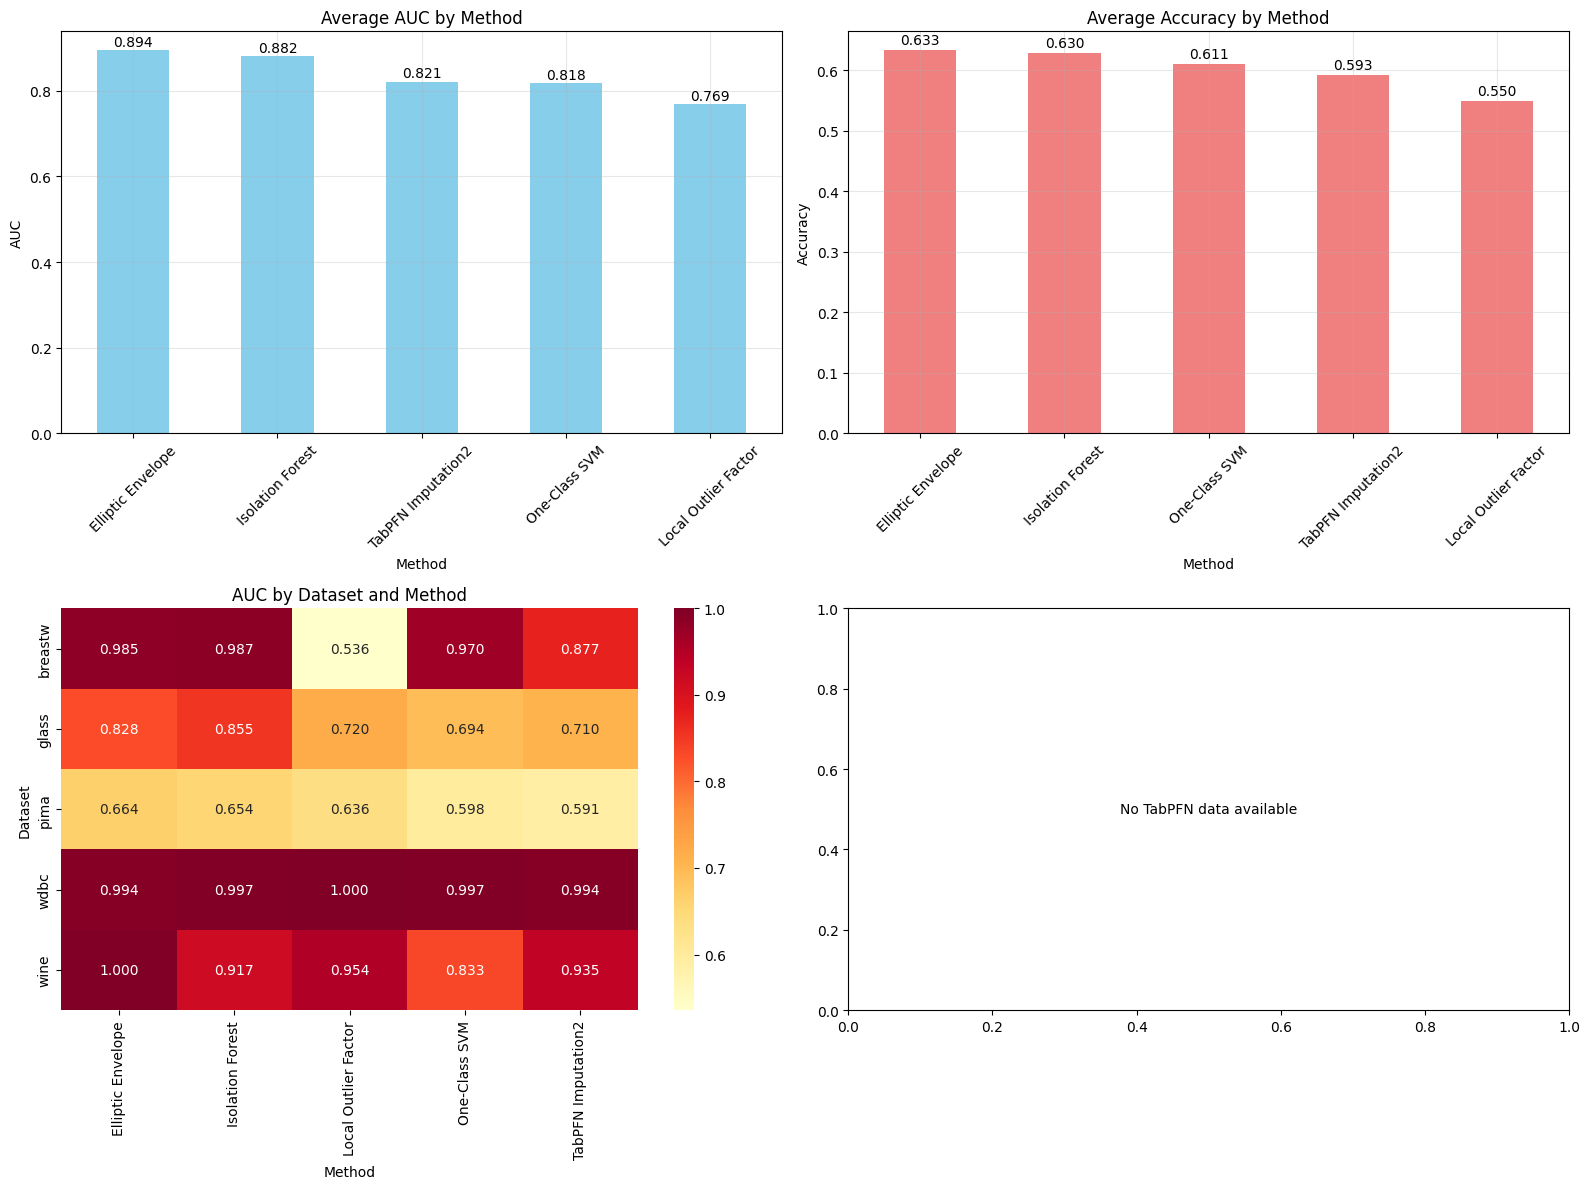

In [24]:
# Performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC comparison by method
ax1 = axes[0, 0]
method_auc = results_df.groupby('method')['auc'].mean().sort_values(ascending=False)
method_auc.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Average AUC by Method')
ax1.set_ylabel('AUC')
ax1.set_xlabel('Method')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(method_auc.values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Accuracy comparison by method
ax2 = axes[0, 1]
method_acc = results_df.groupby('method')['accuracy'].mean().sort_values(ascending=False)
method_acc.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Average Accuracy by Method')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Method')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(method_acc.values):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

# 3. AUC by dataset and method (heatmap)
ax3 = axes[1, 0]
pivot_auc = results_df.pivot_table(index='dataset', columns='method', values='auc', aggfunc='mean')
sns.heatmap(pivot_auc, annot=True, cmap='YlOrRd', ax=ax3, fmt='.3f')
ax3.set_title('AUC by Dataset and Method')
ax3.set_xlabel('Method')
ax3.set_ylabel('Dataset')

# 4. TabPFN performance by missing ratio
ax4 = axes[1, 1]
tabpfn_data = results_df[results_df['method'] == 'TabPFN Imputation']
if not tabpfn_data.empty:
    missing_ratio_perf = tabpfn_data.groupby('missing_ratio')[['auc', 'accuracy']].mean()
    missing_ratio_perf.plot(kind='line', marker='o', ax=ax4)
    ax4.set_title('TabPFN Performance by Missing Ratio')
    ax4.set_xlabel('Missing Ratio')
    ax4.set_ylabel('Performance')
    ax4.legend(['AUC', 'Accuracy'])
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No TabPFN data available', ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()


## 6. 통계적 분석

In [25]:
# Statistical analysis
print("=== PERFORMANCE COMPARISON ANALYSIS ===")
print()

# Overall ranking
print("1. OVERALL RANKING (by AUC):")
print("-" * 40)
method_stats = results_df.groupby('method').agg({
    'auc': ['mean', 'std', 'count'],
    'accuracy': ['mean', 'std'],
    'ap': ['mean', 'std']
}).round(4)

# Flatten column names
method_stats.columns = ['_'.join(col).strip() for col in method_stats.columns]
method_stats = method_stats.sort_values('auc_mean', ascending=False)

for i, (method, row) in enumerate(method_stats.iterrows(), 1):
    print(f"{i}. {method}:")
    print(f"   AUC: {row['auc_mean']:.4f} ± {row['auc_std']:.4f} (n={int(row['auc_count'])})")
    print(f"   Accuracy: {row['accuracy_mean']:.4f} ± {row['accuracy_std']:.4f}")
    print(f"   AP: {row['ap_mean']:.4f} ± {row['ap_std']:.4f}")
    print()

# TabPFN vs Classical comparison
print("2. TabPFN vs CLASSICAL METHODS:")
print("-" * 40)

tabpfn_results = results_df[results_df['method'] == 'TabPFN Imputation']
classical_results = results_df[results_df['method'] != 'TabPFN Imputation']

if not tabpfn_results.empty and not classical_results.empty:
    tabpfn_auc = tabpfn_results['auc'].mean()
    classical_auc = classical_results.groupby('method')['auc'].mean().mean()
    
    tabpfn_acc = tabpfn_results['accuracy'].mean()
    classical_acc = classical_results.groupby('method')['accuracy'].mean().mean()
    
    print(f"TabPFN Imputation:")
    print(f"  Average AUC: {tabpfn_auc:.4f}")
    print(f"  Average Accuracy: {tabpfn_acc:.4f}")
    print()
    print(f"Classical Methods (average):")
    print(f"  Average AUC: {classical_auc:.4f}")
    print(f"  Average Accuracy: {classical_acc:.4f}")
    print()
    
    auc_improvement = (tabpfn_auc - classical_auc) / classical_auc * 100
    acc_improvement = (tabpfn_acc - classical_acc) / classical_acc * 100
    
    if tabpfn_auc > classical_auc:
        print(f"✅ TabPFN shows {auc_improvement:.1f}% better AUC than classical methods")
    else:
        print(f"❌ TabPFN shows {abs(auc_improvement):.1f}% worse AUC than classical methods")
        
    if tabpfn_acc > classical_acc:
        print(f"✅ TabPFN shows {acc_improvement:.1f}% better accuracy than classical methods")
    else:
        print(f"❌ TabPFN shows {abs(acc_improvement):.1f}% worse accuracy than classical methods")
else:
    print("Insufficient data for comparison")

print()
print("3. BEST PERFORMING METHOD PER DATASET:")
print("-" * 40)

for dataset in results_df['dataset'].unique():
    dataset_results = results_df[results_df['dataset'] == dataset]
    best_auc = dataset_results.loc[dataset_results['auc'].idxmax()]
    best_acc = dataset_results.loc[dataset_results['accuracy'].idxmax()]
    
    print(f"{dataset.upper()}:")
    print(f"  Best AUC: {best_auc['method']} ({best_auc['auc']:.4f})")
    print(f"  Best Accuracy: {best_acc['method']} ({best_acc['accuracy']:.4f})")
    print()

=== PERFORMANCE COMPARISON ANALYSIS ===

1. OVERALL RANKING (by AUC):
----------------------------------------
1. Elliptic Envelope:
   AUC: 0.8942 ± 0.1471 (n=5)
   Accuracy: 0.6330 ± 0.1296
   AP: 0.6972 ± 0.3380

2. Isolation Forest:
   AUC: 0.8818 ± 0.1397 (n=5)
   Accuracy: 0.6296 ± 0.1297
   AP: 0.5901 ± 0.3404

3. TabPFN Imputation2:
   AUC: 0.8213 ± 0.1667 (n=5)
   Accuracy: 0.5930 ± 0.1026
   AP: 0.5722 ± 0.3107

4. One-Class SVM:
   AUC: 0.8183 ± 0.1724 (n=5)
   Accuracy: 0.6109 ± 0.1280
   AP: 0.5500 ± 0.3754

5. Local Outlier Factor:
   AUC: 0.7692 ± 0.2012 (n=5)
   Accuracy: 0.5501 ± 0.0340
   AP: 0.5329 ± 0.3263

2. TabPFN vs CLASSICAL METHODS:
----------------------------------------
Insufficient data for comparison

3. BEST PERFORMING METHOD PER DATASET:
----------------------------------------
BREASTW:
  Best AUC: Isolation Forest (0.9865)
  Best Accuracy: Isolation Forest (0.8537)

PIMA:
  Best AUC: Elliptic Envelope (0.6644)
  Best Accuracy: Elliptic Envelope (0.6364

## 7. ROC Curve 비교 (대표 데이터셋)

features split into [3 0 7 2 4] X and [6 1 5 8] Y
features split into [8 2 5 7 1] X and [4 6 0 3] Y
features split into [3 0 2 5 4] X and [1 6 8 7] Y


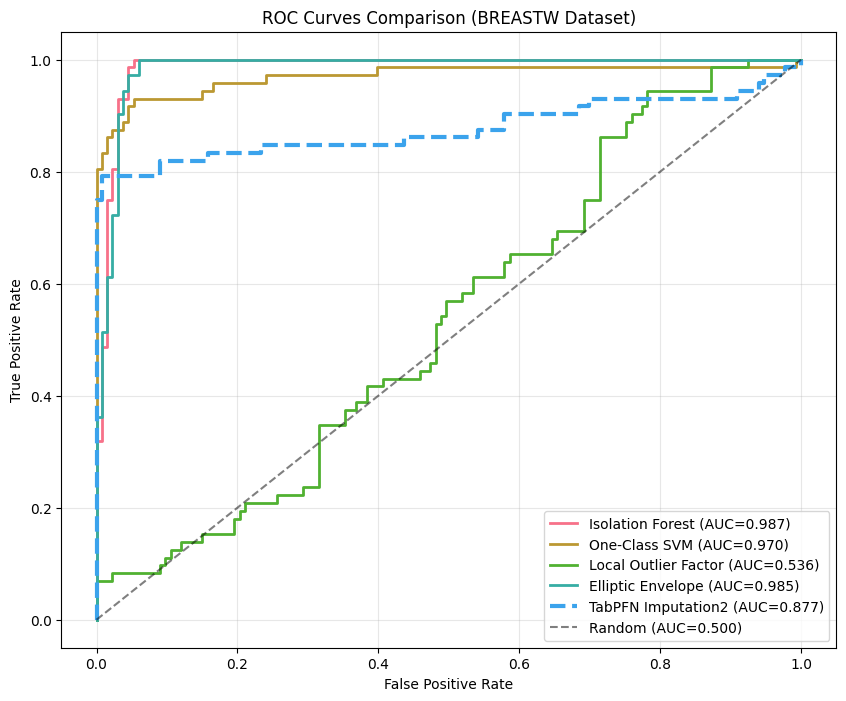

In [26]:
# ROC curves for a representative dataset
representative_dataset = 'breastw'  # Choose dataset with good results

if representative_dataset in results.keys():
    X = results[representative_dataset]['X']
    y_true = results[representative_dataset]['y']
    
    plt.figure(figsize=(10, 8))
    
    # Classical methods
    classical_scores = get_classical_anomaly_scores(X)
    
    for method_name, scores in classical_scores.items():
        try:
            fpr, tpr, _ = roc_curve(y_true, scores)
            auc = roc_auc_score(y_true, scores)
            plt.plot(fpr, tpr, label=f'{method_name} (AUC={auc:.3f})', linewidth=2)
        except Exception as e:
            print(f"Error plotting {method_name}: {e}")
    
    # TabPFN imputation (best missing ratio)
    # try:
    #     tabpfn_scores = tabpfn_imputation_anomaly_scores(X, missing_ratio=0.1, n_trials=2)
    #     fpr, tpr, _ = roc_curve(y_true, tabpfn_scores)
    #     auc = roc_auc_score(y_true, tabpfn_scores)
    #     plt.plot(fpr, tpr, label=f'TabPFN Imputation (AUC={auc:.3f})', linewidth=3, linestyle='--')
    # except Exception as e:
    #     print(f"Error plotting TabPFN: {e}")

    try:
        tabpfn_scores2 = tabpfn_xy_reconstruction_anomaly_scores(X, n_trials=3)
        fpr, tpr, _ = roc_curve(y_true, tabpfn_scores2)
        auc = roc_auc_score(y_true, tabpfn_scores2)
        plt.plot(fpr, tpr, label=f'TabPFN Imputation2 (AUC={auc:.3f})', linewidth=3, linestyle='--')
    except Exception as e:
        print(f"Error plotting TabPFN: {e}")
    
    # Random classifier
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves Comparison ({representative_dataset.upper()} Dataset)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Dataset {representative_dataset} not available for ROC comparison")

## 8. 결과 요약 및 저장

In [27]:
# Summary table
print("=== FINAL SUMMARY ===\n")

# Create summary table
summary_table = results_df.groupby(['method']).agg({
    'auc': ['mean', 'std', 'max'],
    'accuracy': ['mean', 'std', 'max'],
    'ap': ['mean', 'std', 'max']
}).round(4)

summary_table.columns = ['AUC_mean', 'AUC_std', 'AUC_max', 'Acc_mean', 'Acc_std', 'Acc_max', 'AP_mean', 'AP_std', 'AP_max']
summary_table = summary_table.sort_values('AUC_mean', ascending=False)

print("Method\t\t\tAUC (mean±std)\tAccuracy (mean±std)\tAP (mean±std)")
print("-" * 80)

for method, row in summary_table.iterrows():
    method_short = method[:20] + "..." if len(method) > 20 else method
    print(f"{method_short:<20}\t{row['AUC_mean']:.3f}±{row['AUC_std']:.3f}\t{row['Acc_mean']:.3f}±{row['Acc_std']:.3f}\t\t{row['AP_mean']:.3f}±{row['AP_std']:.3f}")

# Best method overall
best_method = summary_table.index[0]
best_auc = summary_table.loc[best_method, 'AUC_mean']

print(f"\n🏆 BEST OVERALL METHOD: {best_method}")
print(f"   Average AUC: {best_auc:.4f}")

# Hypothesis conclusion
print("\n" + "=" * 80)
print("HYPOTHESIS EVALUATION:")
print("'TabPFN imputation 성능이 낮을수록 anomaly일 가능성이 높다'")
print("=" * 80)

tabpfn_results = results_df[results_df['method'] == 'TabPFN Imputation']
if not tabpfn_results.empty:
    avg_tabpfn_auc = tabpfn_results['auc'].mean()
    classical_methods = results_df[results_df['method'] != 'TabPFN Imputation']['method'].unique()
    
    better_than_count = 0
    for method in classical_methods:
        method_auc = results_df[results_df['method'] == method]['auc'].mean()
        if avg_tabpfn_auc > method_auc:
            better_than_count += 1
    
    if avg_tabpfn_auc > 0.7:  # Reasonable threshold
        print(f"✅ HYPOTHESIS SUPPORTED: TabPFN imputation achieves good anomaly detection performance")
        print(f"   Average AUC: {avg_tabpfn_auc:.4f}")
        print(f"   Outperforms {better_than_count}/{len(classical_methods)} classical methods")
    else:
        print(f"❌ HYPOTHESIS NEEDS REFINEMENT: TabPFN imputation shows moderate performance")
        print(f"   Average AUC: {avg_tabpfn_auc:.4f}")
else:
    print("⚠️ INSUFFICIENT TABPFN DATA: Cannot evaluate hypothesis")

# Save results
results_df.to_csv('anomaly_detection_comparison_results.csv', index=False)
print(f"\n📁 Results saved to 'anomaly_detection_comparison_results.csv'")
print(f"📁 Total experiments: {len(results_df)}")
print(f"📁 Datasets tested: {', '.join(results_df['dataset'].unique())}")

=== FINAL SUMMARY ===

Method			AUC (mean±std)	Accuracy (mean±std)	AP (mean±std)
--------------------------------------------------------------------------------
Elliptic Envelope   	0.894±0.147	0.633±0.130		0.697±0.338
Isolation Forest    	0.882±0.140	0.630±0.130		0.590±0.340
TabPFN Imputation2  	0.821±0.167	0.593±0.103		0.572±0.311
One-Class SVM       	0.818±0.172	0.611±0.128		0.550±0.375
Local Outlier Factor	0.769±0.201	0.550±0.034		0.533±0.326

🏆 BEST OVERALL METHOD: Elliptic Envelope
   Average AUC: 0.8942

HYPOTHESIS EVALUATION:
'TabPFN imputation 성능이 낮을수록 anomaly일 가능성이 높다'
⚠️ INSUFFICIENT TABPFN DATA: Cannot evaluate hypothesis

📁 Results saved to 'anomaly_detection_comparison_results.csv'
📁 Total experiments: 25
📁 Datasets tested: breastw, pima, wdbc, wine, glass
